# Goal

Based on the Bank data indetify not satisfied clients (TARGET=1) Score - roc_auc_score

In [1]:
# Load

# Import data and modules
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from random import shuffle
import scipy
from scipy.cluster import hierarchy as hc

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from catboost import Pool, CatBoostClassifier

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import gc
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from catboost import Pool, CatBoostClassifier

from sklearn.preprocessing import StandardScaler

from numpy import argmax

from sklearn.decomposition import PCA

# Data

In [2]:
# test set almast the same size as train
train=pd.read_csv('train.csv')
train=train.drop(['ID'],axis=1)
test=pd.read_csv('test.csv')
test=test.drop(['ID'],axis=1)

print(train.shape)
print(test.shape)

# No NaN data
print('Null_train:',train.isnull().sum().sum())
print('Null_test:',train.isnull().sum().sum())


#very imbalanced dataset
print('Very imbalanced dataset \n',train['TARGET'].value_counts())

(76020, 370)
(75818, 369)
Null_train: 0
Null_test: 0
Very imbalanced dataset 
 0    73012
1     3008
Name: TARGET, dtype: int64


### So
- 1. We will use cross-val
- 2. Imbalanced measures required



# Data Analysis

In [3]:
X_train=train.drop(['TARGET'],axis=1)
y_train=train['TARGET']

X_test=test.copy()

#True
X_train.columns==X_test.columns

# simplify names of columns

col_name=pd.DataFrame(list(range(1,(int(len(X_train.columns)+1))))).T
X_train.columns=col_name.columns
X_train.columns=X_train.columns.astype(str)
X_test.columns=col_name.columns
X_test.columns=X_test.columns.astype(str)

#Save columns name
Columns_Dict = {'Old': train.columns,
            'New': X_train.columns
            }
np.save('columns_dict.npy', Columns_Dict) 

X_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '359', '360', '361', '362', '363', '364', '365', '366', '367', '368'],
      dtype='object', length=369)

In [4]:
#drop columns with constant value
low_var=[]
for i  in range(0,369):
    if X_train[str(i)].value_counts().count()==1:
        low_var.append(str(i))
    else:
        continue
print('Columns with only 1 value=',len(low_var))

#drop these coumns

for i in [X_train,X_test]:
    X_train_=X_train.drop(low_var,axis=1)
    X_test_=X_test.drop(low_var,axis=1)
print('Train_set_size',X_train_.shape)
print('Test_set_size',X_test_.shape)

Columns with only 1 value= 34
Train_set_size (76020, 335)
Test_set_size (75818, 335)


# Baseline score

### helper

In [5]:
#calculate score
def score_cv(m,col,scor):
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
    scorer = make_scorer(scor, greater_is_better = True,average='weighted')
    score= cross_val_score(m, X_train_[col], y_train, scoring = scorer, cv = kf) 
    return(score.mean())

In [140]:
#Check Confusion matrix

def conf_matrix(m,col):
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
    pred_full=[]
    y_full=[]
    for i in [0.5]:
        threshold = i
        sc=[]
        for train, test in kf.split(X_train_,y_train):
                m.fit(X_train_.iloc[train][col], y_train.iloc[train])
                pred = m.predict(X_train_.iloc[test][col])
                # list to write data
                pred_full=pred_full+list(pred)

                y_full=y_full+list(y_train.iloc[test].values)


                #score=roc_auc_score(y_train.iloc[test].values,pred,average='weighted')
                #sc.append(score)
    print('Roc_AUC: \n',roc_auc_score(y_full,pred_full,average='weighted'))
    print('Confusion_matrix_Baseline: \n',confusion_matrix(y_full,pred_full))

In [43]:
### Calculate baseline -XGBoost-cross_val - auc=0.5
m=XGBClassifier(random_state=243, n_jobs=-1)
col=X_train_.columns
score_cv(m,col,roc_auc_score)

0.5004644292660723

## Tune baseline score

### scale_pos_weight
- This parameter important for imbalanced ds.
- To find it we have to number of negative class/positive class (f.e. 73012/3008=24)


In [44]:
# check score with tunned scale_pos_weight auc=0.762
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24)
col=X_train_.columns
score_cv(m,col,roc_auc_score)

0.76254152079052

In [46]:
#check test score (Kaggle) with tunned -0.757
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24)
m.fit(X_train_,y_train)
pred_scale_pos=m.predict(X_test_)

In [47]:
submission = pd.read_csv("sample_submission.csv", index_col='ID')
submission['TARGET'] = pred_scale_pos.astype(int)
submission.to_csv('sample_submission.csv')

In [56]:
### n_estimators 40-0.7623422858352633
#for n in [40,90,100,105,500]:
#for l in [0.3,0.5,1]:
#for m in [6,10,15,25,None]:
#for s in [1,0.1,0.2,0.5,0.8]:
#for w in [25,45,70]:
    m=XGBClassifier(random_state=243, n_jobs=-1,
                    #learning_rate=l,
                    #max_depth=m,
                    #subsample=s,
                    scale_pos_weight=24,
                    n_estimators=n
                   )
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
    col=X_train_.columns
    print(n)
    print(score_cv(m,col,roc_auc_score))

40
0.7623422858352633
90
0.7615323508464362
100
0.76254152079052
105
0.7625446352596076
500
0.7547540093962986


In [57]:
#submit X_test_with n_est
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24,n_estimators=105)
m.fit(X_train_,y_train)
pred_n_est105=m.predict(X_test_)
submission = pd.read_csv("sample_submission.csv", index_col='ID')
submission['TARGET'] = pred_scale_pos.astype(int)
submission.to_csv('sample_submission.csv')

# tune threshold

### Feature Importance

In [7]:
col=X_train_.columns
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24, n_estimators=105)
m.fit(X_train_[col],y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=105, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=243,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=24, seed=None,
              silent=None, subsample=1, verbosity=1)

In [8]:
importance = m.feature_importances_
feat_impot=pd.DataFrame((zip(X_train_[col].columns, importance)), columns=['Feat','Importance']).sort_values(by='Importance',ascending=False)
feat_impot['Feat']=feat_impot['Feat'].astype(str)
fi_no_imp=feat_impot[feat_impot.Importance==0]
print('Amount of feat importance == 0,',len (fi_no_imp))
fi=feat_impot[feat_impot.Importance>0]
print('Amount of feat importance > 0,',len (fi))
col_fi=list(fi['Feat'].values)

Amount of feat importance == 0, 263
Amount of feat importance > 0, 72


Amount of feat importance > 0, 72


Text(0.5, 1.0, '')

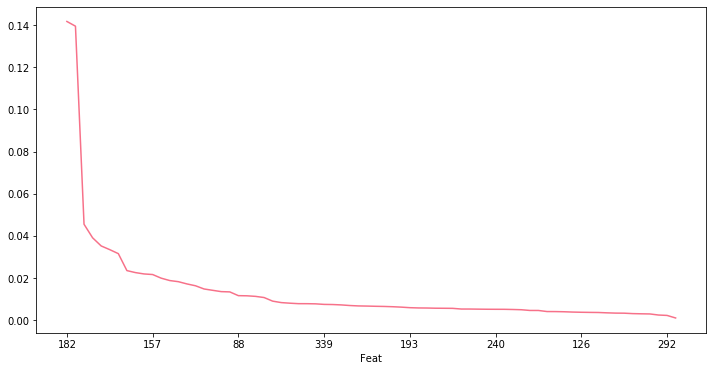

In [9]:
fi.plot('Feat', 'Importance', figsize=(12,6), legend=False)
plt.title(print('Amount of feat importance > 0,',len (fi)))

In [10]:
def plot_fi(fi): return fi.plot('Feat', 'Importance', 'barh', figsize=(12,9), legend=False)

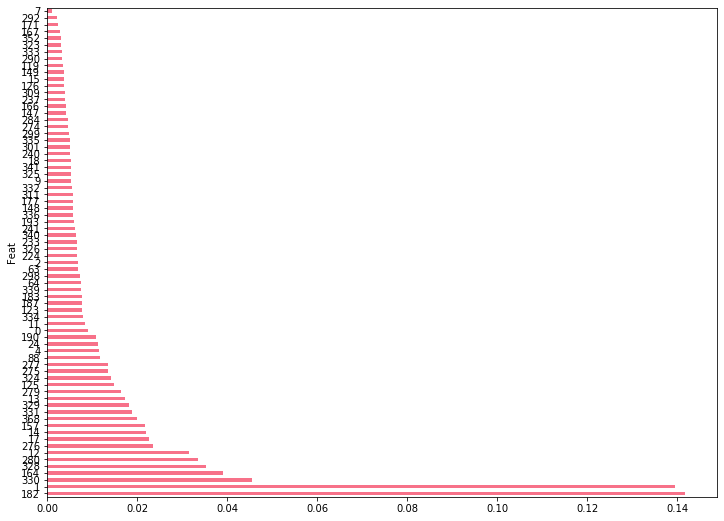

In [11]:
# We see that some feat has huge importance
plot_fi(fi)

In [208]:
### Calculate Score with different FI threshold
### i=0.008 (0.009,0.008,0.0075) 0.7651724639989229
for i in [0.0085,0.008,0.0075,0.007]:
    col_fi_thr = fi[fi.Importance>i]['Feat'].values
    m=XGBClassifier(random_state=243, n_jobs=-1,
                    #learning_rate=l,
                    #max_depth=m,
                    #subsample=s,
                    scale_pos_weight=24,
                    n_estimators=105
                   )
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
    col=col_fi_thr
    print(score_cv(m,col,roc_auc_score))

0.7648281876718603
0.7651724639989229
0.7633601890420811
0.7631236168843127


In [12]:
# Remember columns feat imp 0.008- 27 columns
col_fi_008=fi[fi.Importance>0.008]['Feat'].values
print('FI_col_0.008, amount =',len(col_fi_008))

FI_col_0.008, amount = 27


## Dengdrogram to define rebundent features (colinear)

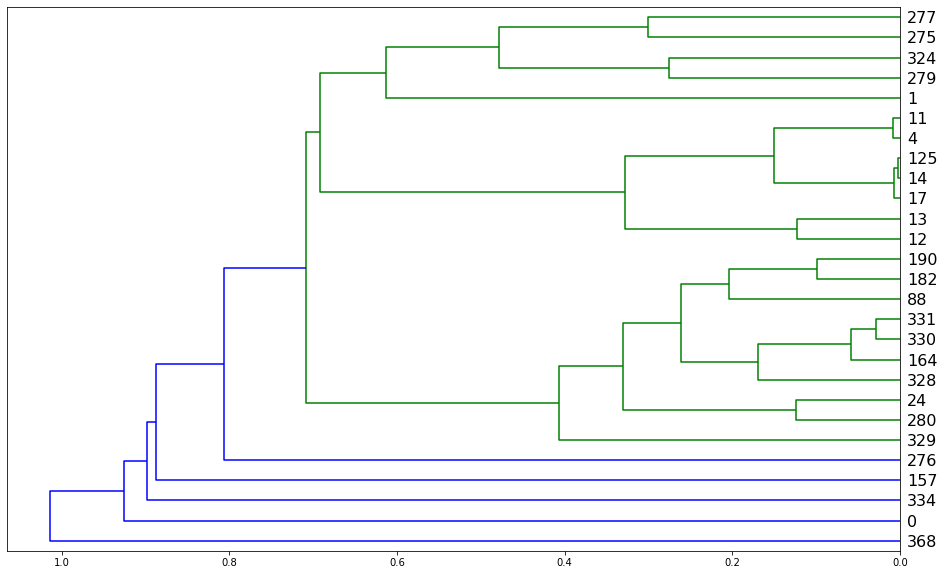

In [13]:
# There are some colinear features
col=col_fi_008

corr = np.round(scipy.stats.spearmanr(X_train_[col]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_[col].columns, orientation='left', leaf_font_size=16)
plt.show()

In [235]:
#try to drop colinear by one (or by few if score improved)and measure score

m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24,n_estimators=105)
shuffle(col_fi_008)

feat_list=['24']
col1=X_train_[col_fi_008].columns.drop(feat_list)
drop=[]
info=[]
my=0.76517

for i in list(col1):
    info.append(i)
    print(info)
    drop=i
    keep_col=X_train_[col_fi_008].columns.drop(drop)
    keep_col_1=X_train[keep_col].columns.drop(feat_list)
    sc=score_cv(m,keep_col_1,roc_auc_score)
    print(sc)
    if round(sc,5)>=my:
        my=sc
        feat_list.append(i)
        print(i)
        print(sc)
    else:
        continue


['17']
0.7644758155464971
['17', '324']
0.7626928002071358
['17', '324', '88']
0.7630227609043573
['17', '324', '88', '280']
0.7636671099533623
['17', '324', '88', '280', '13']
0.7642093554134499
['17', '324', '88', '280', '13', '164']
0.76495892252046
['17', '324', '88', '280', '13', '164', '4']
0.7633651703712943
['17', '324', '88', '280', '13', '164', '4', '157']
0.7612328973756572
['17', '324', '88', '280', '13', '164', '4', '157', '190']
0.7648599334006301
['17', '324', '88', '280', '13', '164', '4', '157', '190', '329']
0.7634168414169166
['17', '324', '88', '280', '13', '164', '4', '157', '190', '329', '334']
0.7645729378062014
['17', '324', '88', '280', '13', '164', '4', '157', '190', '329', '334', '14']
0.7651145640151255
['17', '324', '88', '280', '13', '164', '4', '157', '190', '329', '334', '14', '125']
0.7628839302574569
['17', '324', '88', '280', '13', '164', '4', '157', '190', '329', '334', '14', '125', '279']
0.7647167406756803
['17', '324', '88', '280', '13', '164', '4

In [237]:
feat_list

['24']

In [14]:
# Remember columns feat imp 0.008 and drop colin '24'
col_fi_008_dr_col=X_train_[col_fi_008].drop(['24'],axis=1).columns
print('FI_col_0.008_dr_col, amount =',len(col_fi_008_dr_col))

FI_col_0.008_dr_col, amount = 26


In [250]:
#check score with new share columns
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24,n_estimators=105)
col=col_fi_008_dr_col
print('Amount_columns=', len(col_fi_008_dr_col))
score_cv(m,col,roc_auc_score)

Amount_columns= 26


0.7654021879673525

In [251]:
#submit X_test_with n_est - fi-drop colin Kaggle 0.75788
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24,n_estimators=105)
col=col_fi_008_dr_col.copy()
m.fit(X_train_[col],y_train)
pred_n_est105_dr_col_feat=m.predict(X_test_[col])
submission = pd.read_csv("sample_submission.csv", index_col='ID')
submission['TARGET'] = pred_n_est105_dr_col_feat.astype(int)
submission.to_csv('sample_submission.csv')

## Threshold tune

In [70]:
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24,n_estimators=105)
col=col_fi_008_dr_col.copy()

pred_proba_list=[]
y_train_list=[]
for i in [0.5]:
    threshold = i
    sc=[]
    for train, test in kf.split(X_train_,y_train):
            m.fit(X_train_.iloc[train][col], y_train.iloc[train])
            pred_proba = m.predict_proba(X_train_.iloc[test][col])
            # list to write data
            pred_proba_list.append((pred_proba [:,1]).T)
            y_train_list.append(y_train.iloc[test].values)
            pred = (pred_proba [:,1] >=threshold).astype('int')
            score=roc_auc_score(y_train.iloc[test].values,pred,average='weighted')
            sc.append(score)
            
    print(np.mean(sc))
            

0.7654021879673525


## Check Mistakes

0.6547984480857849
0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000008C34B00>,
      dtype=object)

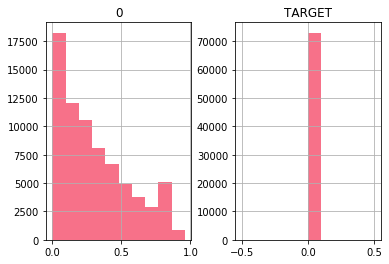

In [82]:

a=pd.DataFrame(pred_proba_list[0])
b=pd.DataFrame(pred_proba_list[1])

a_y=pd.DataFrame(y_train_list[0])
b_y=pd.DataFrame(y_train_list[1])

c=pd.concat([a,b],axis=0)
c_y=pd.concat([a_y,b_y],axis=0)

compare=pd.concat([c_y,c],axis=1)
compare.columns=['TARGET','0']

class_1=compare.loc[compare['TARGET']==1]
print(np.mean(class_1['0']))

class_0=compare.loc[compare['TARGET']==0]
print(np.mean(class_0['TARGET']))

class_0.hist()

# Conclusion 

We improved roc_auc_score from baseline 0.5 to 0.7654
We identified 78 % unsatisfied client, but more satisfied cliens was as well identifies as non satisfied.

In [133]:
#Tunned confusion matrix

m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=24,n_estimators=105)
col=col_fi_008_dr_col.copy()
conf_matrix(m,col)

Roc_AUC: 
 0.7654021879673526
Confusion_matrix_Baseline: 
 [[56644 16368]
 [  737  2271]]


In [134]:
#Baseline confusion matrix
m=XGBClassifier(random_state=243, n_jobs=-1)
col=X_train_.columns
conf_matrix(m,col)

Roc_AUC: 
 0.5004644292660723
Confusion_matrix_Baseline: 
 [[73007     5]
 [ 3005     3]]


In [139]:
m=XGBClassifier(random_state=243, n_jobs=-1,scale_pos_weight=21,n_estimators=105)
col=col_fi_008_dr_col.copy()
conf_matrix(m,col)

Roc_AUC: 
 0.7633926268750926
Confusion_matrix_Baseline: 
 [[58438 14574]
 [  823  2185]]
